
=== Running attacks ===
Loading base model (model_1.pth)
Loading defense model (modelF1.pth)

FGSM attack (epsilon=0.005) – base model
Overall accuracy: 0.3668
Class plane:  41.7%
Class car  :  58.4%
Class bird :  32.0%
Class cat  :  17.0%
Class deer :  21.0%
Class dog  :  31.2%
Class frog :  30.5%
Class horse:  45.4%
Class ship :  62.1%
Class truck:  51.8%


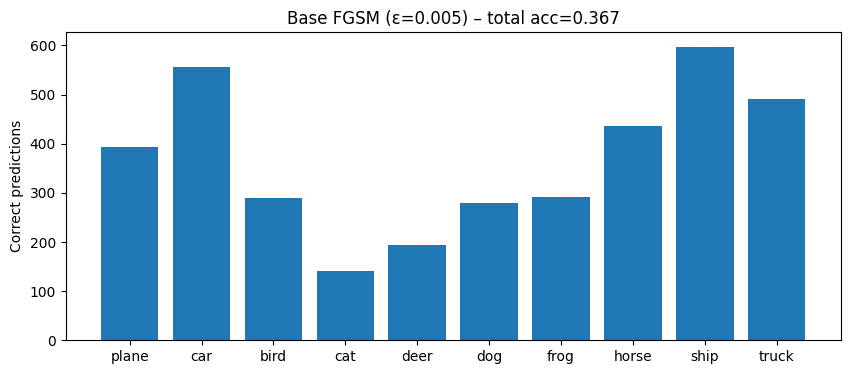

FGSM attack – defense model
Overall accuracy: 0.8873
Class plane:  98.1%
Class car  :  98.5%
Class bird :  97.1%
Class cat  :  94.2%
Class deer :  97.6%
Class dog  :  95.5%
Class frog :  97.0%
Class horse:  97.9%
Class ship :  98.8%
Class truck:  97.0%


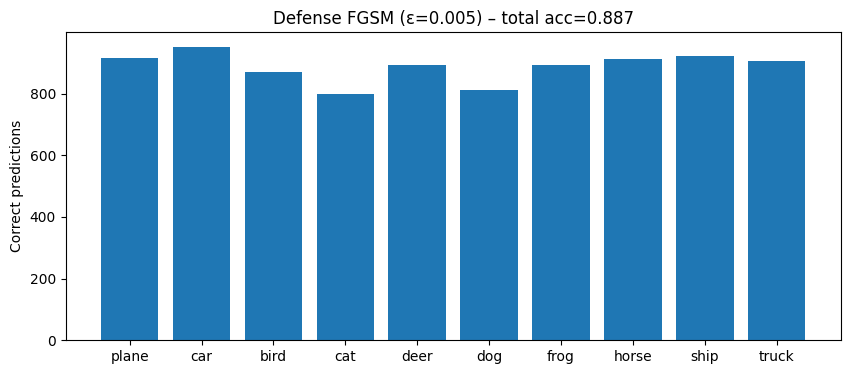


Semantic attack – base model
Overall accuracy: 0.5849
Class plane:  84.6%
Class car  :  56.0%
Class bird :  74.6%
Class cat  :  63.8%
Class deer :  53.3%
Class dog  :  44.2%
Class frog :  56.6%
Class horse:  59.7%
Class ship :  79.2%
Class truck:  58.2%


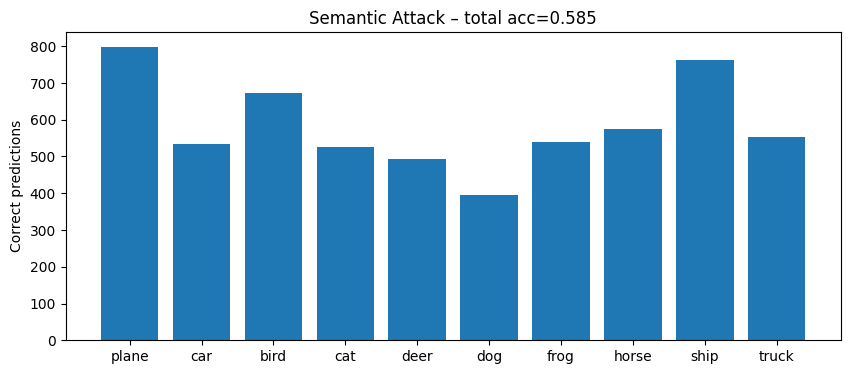


Defense model already exists. Skipping training.

=== Running attacks ===
Loading base model (model_1.pth)
Loading defense model (modelF1.pth)

FGSM attack (epsilon=0.005) – base model
Overall accuracy: 0.3668
Class plane:  41.7%
Class car  :  58.4%
Class bird :  32.0%
Class cat  :  17.0%
Class deer :  21.0%
Class dog  :  31.2%
Class frog :  30.5%
Class horse:  45.4%
Class ship :  62.1%
Class truck:  51.8%


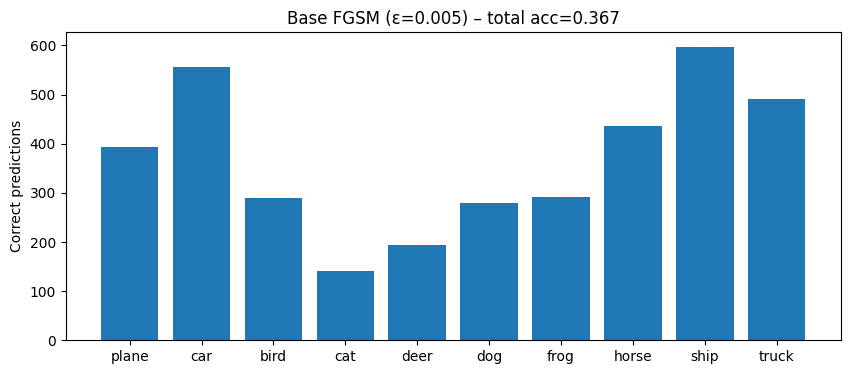

FGSM attack – defense model
Overall accuracy: 0.8873
Class plane:  98.1%
Class car  :  98.5%
Class bird :  97.1%
Class cat  :  94.2%
Class deer :  97.6%
Class dog  :  95.5%
Class frog :  97.0%
Class horse:  97.9%
Class ship :  98.8%
Class truck:  97.0%


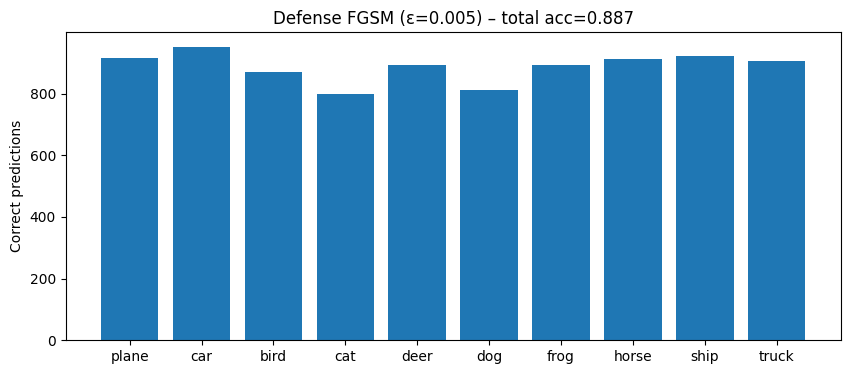


Semantic attack – base model
Overall accuracy: 0.5849
Class plane:  84.6%
Class car  :  56.0%
Class bird :  74.6%
Class cat  :  63.8%
Class deer :  53.3%
Class dog  :  44.2%
Class frog :  56.6%
Class horse:  59.7%
Class ship :  79.2%
Class truck:  58.2%


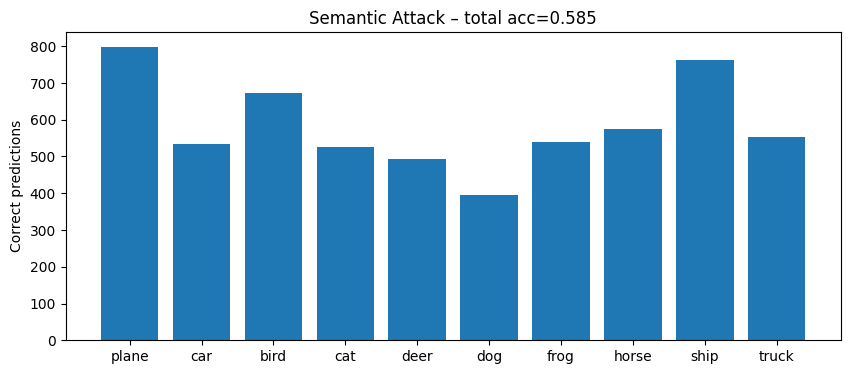

In [3]:
"""
EN.520.665 Machine Perception
Project 1
Team Member: Danny (Iou-Sheng) Chang, Juo-Tung Chen

Attack + Defensive Distillation on CIFAR-10 (GoogLeNet)
"""

import argparse
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms

from models import GoogLeNet
from misc import progress_bar


CLASSES = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# =====================================================
# Main
# =====================================================
def main():
    parser = argparse.ArgumentParser(description="CIFAR-10 adversarial attacks + defense")
    parser.add_argument('--lr', default=0.001, type=float)
    parser.add_argument('--trainBatchSize', default=50, type=int)
    parser.add_argument('--testBatchSize', default=1, type=int)
    parser.add_argument('--cuda', default=torch.cuda.is_available(), type=bool)

    args, _ = parser.parse_known_args()

    solver = Solver(args)

    # 1) Attack pretrained model
    solver.run_attack()

    # 2) Train defense once
    if not os.path.exists("modelF1.pth"):
        solver.defense()
    else:
        print("\nDefense model already exists. Skipping training.")

    # 3) Attack defended model
    solver.run_attack()


# =====================================================
# Solver
# =====================================================
class Solver(object):
    def __init__(self, config):
        self.lr = config.lr
        self.train_batch_size = config.trainBatchSize
        self.test_batch_size = config.testBatchSize
        self.device = torch.device('cuda' if config.cuda else 'cpu')

        self.model = None
        self.model_defense = None

        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.Temp = 100

        self.train_loader = None
        self.test_loader = None

    # =================================================
    # Data
    # =================================================
    def load_data(self):
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor()
        ])

        trainset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform_train
        )

        testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=transform_test
        )

        self.train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=self.train_batch_size, shuffle=True
        )

        self.test_loader = torch.utils.data.DataLoader(
            testset, batch_size=self.test_batch_size, shuffle=False
        )

    # =================================================
    # Models
    # =================================================
    def load_model(self):
        cudnn.benchmark = True

        print("Loading base model (model_1.pth)")
        self.model = torch.load(
            "model_1.pth",
            map_location=self.device,
            weights_only=False
        ).to(self.device)
        self.model.eval()

        if os.path.exists("modelF1.pth"):
            print("Loading defense model (modelF1.pth)")
            self.model_defense = torch.load(
                "modelF1.pth",
                map_location=self.device,
                weights_only=False
            ).to(self.device)
            self.model_defense.eval()
        else:
            self.model_defense = None

    # =================================================
    # Attacks
    # =================================================
    def fgsm_attack(self, x, eps, grad):
        return torch.clamp(x + eps * grad.sign(), 0, 1)

    def semantic_attack(self, x):
        return torch.max(x) - x

    # =================================================
    # Run attacks
    # =================================================
    def run_attack(self):
        print("\n=== Running attacks ===")
        self.load_data()
        self.load_model()

        eps = 0.005

        # FGSM – base
        print(f"\nFGSM attack (epsilon={eps}) – base model")
        self.test_attack(self.model, eps, fgsm=True, title="Base FGSM")

        # FGSM – defense
        if self.model_defense:
            print("FGSM attack – defense model")
            self.test_attack(self.model_defense, eps, fgsm=True, title="Defense FGSM")

        # Semantic
        print("\nSemantic attack – base model")
        self.test_attack(self.model, 0, fgsm=False, title="Semantic Attack")

    # =================================================
    # Attack evaluation + plots
    # =================================================
    def test_attack(self, model, epsilon, fgsm=True, title=""):
        model.eval()

        correct = 0
        class_correct = [0] * 10
        class_total = [0] * 10

        for data, target in self.test_loader:
            data, target = data.to(self.device), target.to(self.device)

            if fgsm:
                data.requires_grad = True
                output = model(data)
                init_pred = output.max(1)[1]
                if init_pred.item() != target.item():
                    continue

                loss = self.criterion(output, target)
                model.zero_grad()
                loss.backward()
                perturbed = self.fgsm_attack(data, epsilon, data.grad.data)
            else:
                with torch.no_grad():
                    output = model(data)
                    init_pred = output.max(1)[1]
                    if init_pred.item() != target.item():
                        continue
                    perturbed = self.semantic_attack(data)

            with torch.no_grad():
                final_pred = model(perturbed).max(1)[1]

            label = target.item()
            class_total[label] += 1
            if final_pred.item() == label:
                correct += 1
                class_correct[label] += 1

        acc = correct / len(self.test_loader)
        print(f"Overall accuracy: {acc:.4f}")

        # Per-class print
        for i, cls in enumerate(CLASSES):
            if class_total[i] > 0:
                a = 100.0 * class_correct[i] / class_total[i]
            else:
                a = 0.0
            print(f"Class {cls:5s}: {a:5.1f}%")

        # Plot per-class bar chart
        xs = np.arange(len(CLASSES))
        plt.figure(figsize=(10, 4))
        plt.bar(xs, class_correct)
        plt.xticks(xs, CLASSES)
        plt.ylabel("Correct predictions")
        if fgsm:
            plt.title(f"{title} (ε={epsilon}) – total acc={acc:.3f}")
        else:
            plt.title(f"{title} – total acc={acc:.3f}")
        plt.show()

    # =================================================
    # Defensive Distillation
    # =================================================
    def defense(self):
        print("\n=== Training defensive distillation model ===")
        self.load_data()
        self.load_model()

        student = GoogLeNet().to(self.device)
        optimizer = optim.Adam(student.parameters(), lr=self.lr)
        kl_loss = nn.KLDivLoss(reduction='batchmean')

        student.train()
        self.model.eval()

        for epoch in range(1, 101):
            print(f"\nEpoch {epoch}/100")
            for batch_idx, (data, _) in enumerate(self.train_loader):
                data = data.to(self.device)

                with torch.no_grad():
                    teacher_logits = self.model(data)

                student_logits = student(data)

                soft_teacher = torch.softmax(teacher_logits / self.Temp, dim=1)
                soft_student = torch.log_softmax(student_logits / self.Temp, dim=1)

                loss = kl_loss(soft_student, soft_teacher) * (self.Temp ** 2)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                progress_bar(
                    batch_idx, len(self.train_loader),
                    f"Loss: {loss.item():.4f}"
                )

        torch.save(student, "modelF1.pth")
        print("\nDefense model saved as modelF1.pth")


# =====================================================
# Entry
# =====================================================
if __name__ == "__main__":
    main()